In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

In [2]:
modules = (fc.eightb.preselection, fc.eightb.preselection_y)
labels = ['t8btag_minmass','t8btag_y']

In [3]:
signals = ObjIter([Tree(module.NMSSM_XYY_YToHH_8b_MX_1000_MY_450) for module in modules])
qcds = ObjIter([Tree(module.QCD_B_List) for module in modules])

In [4]:
varinfo.Y1_m = dict(bins=(0,1000,30))
varinfo.Y2_m = dict(bins=(0,1000,30))
varinfo.H1Y1_m = dict(bins=(0,500,30))
varinfo.H2Y1_m = dict(bins=(0,500,30))
varinfo.H1Y2_m = dict(bins=(0,500,30))
varinfo.H2Y2_m = dict(bins=(0,500,30))


In [29]:
signals.H1Y1_b1_genHflag

[<Array [0, 0, 2, 2, -1, 2, ... 3, 1, 0, 2, 0] type='62904 * int32'>, <Array [0, 1, 0, 0, -1, 4, ... 6, -1, 0, 4, 0] type='62904 * int32'>]

In [31]:
def fix_jet_genHflag(tree):
  flags = [f'{obj}_genHflag' for obj in eightb.quarklist]
  genHflag = {key:(value+2)//2-1 for key, value in zip(flags, ak.unzip(tree[flags]))}
  tree.extend(**genHflag)

fix_jet_genHflag(signals[1])

In [33]:
def get_jet_signalId(tree):
  signalId = ak.concatenate([ id[:,None] for id in ak.unzip(tree[[f'{obj}_genHflag' for obj in eightb.quarklist]])], axis=-1)
  return signalId

def nfound_paired_y(tree):
  signalId = get_jet_signalId(tree)
  signalId = (signalId+2)//2

  n_y1 = ak.sum(signalId == 1,axis=-1) == 4
  n_y2 = ak.sum(signalId == 2,axis=-1) == 4

  n_y = 1*ak.all(signalId[:,:4] == 1,axis=-1) + \
    1*ak.all(signalId[:,4:] == 2, axis=-1)

  tree.extend(nfound_paired_y=n_y,)
  # return n_y

signals.apply(nfound_paired_y)

[None, None]

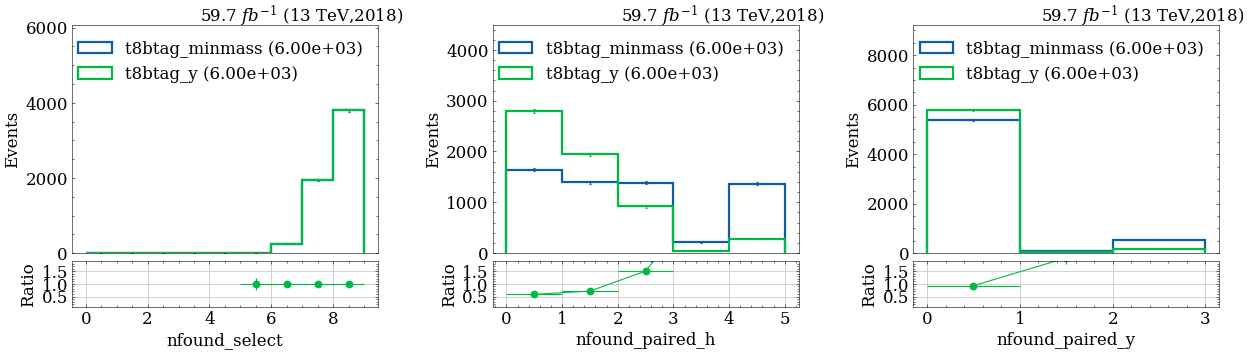

In [40]:
study.quick(
  signals,h_color=None,label=labels,legend=True, dim=(-1,3),
  masks=lambda t:t.nfound_presel==8,
  varlist=['nfound_select','nfound_paired_h','nfound_paired_y'],
  ratio=True,
)

In [36]:
eightb_trees = signals.apply(EventFilter('all_eightb',nfound_select=8))

In [42]:
eightb_trees.apply(lambda t: ak.mean(t.nfound_paired_h==4)),eightb_trees.apply(lambda t: ak.mean(t.nfound_paired_y==2))

([0.36039012112631746, 0.07566462167689161],
 [0.14189082900739342, 0.04656284410885638])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


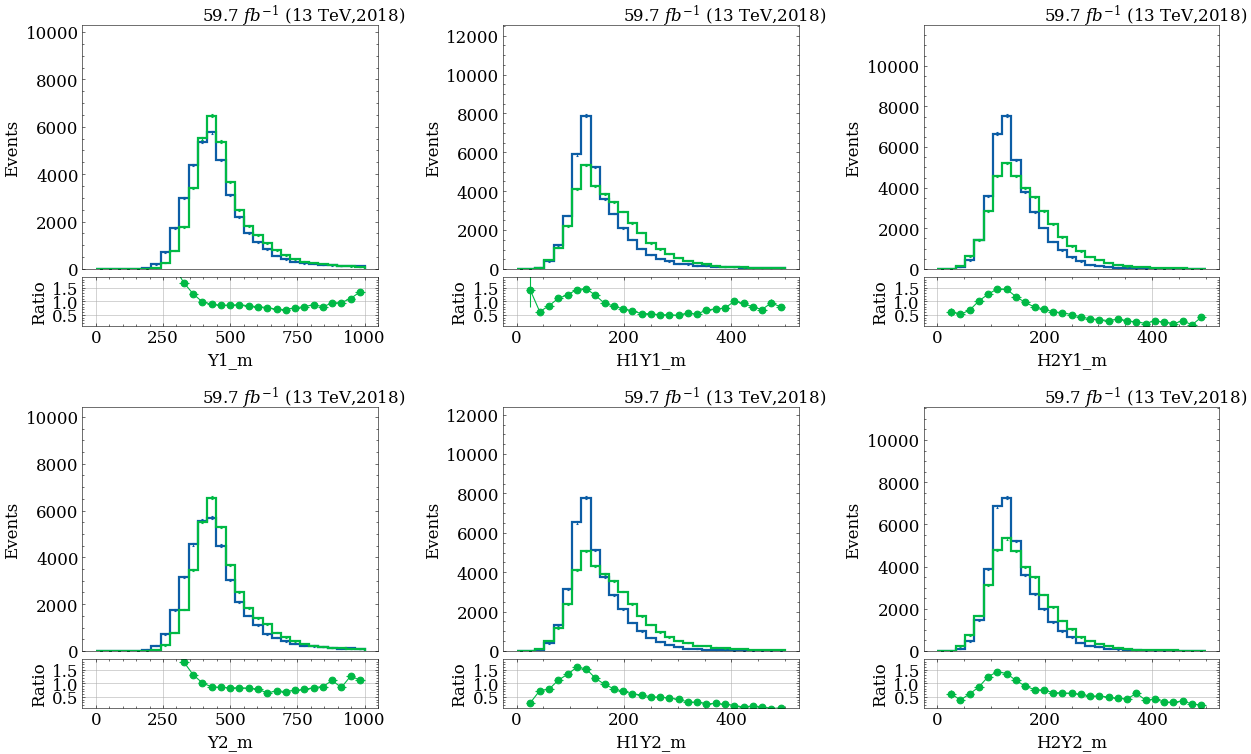

In [5]:
study.quick(
  signals,h_color=None,label=labels,
  varlist=[f'{h}{obj}_m' for obj in eightb.ylist for h in ['','H1','H2']],
  dim=(-1,3), ratio=True,
)

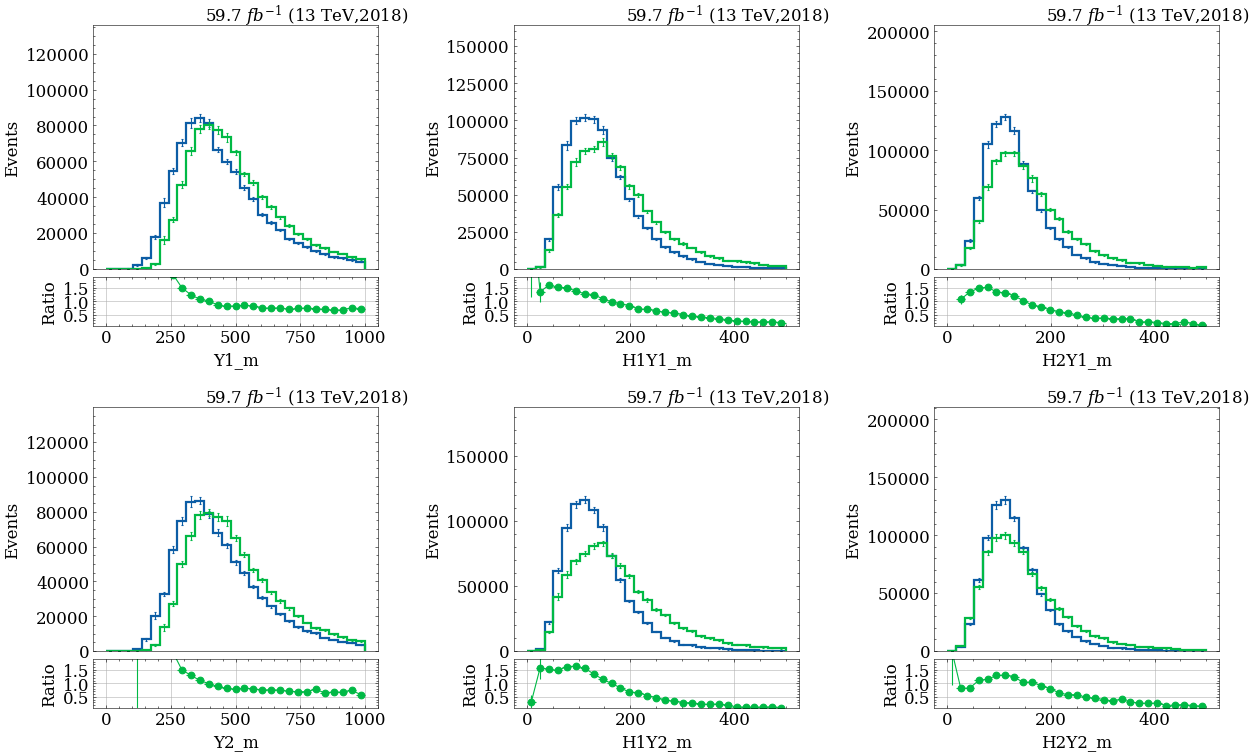

In [6]:
study.quick(
  qcds,h_color=None,label=labels,
  varlist=[f'{h}{obj}_m' for obj in eightb.ylist for h in ['','H1','H2']],
  dim=(-1,3), ratio=True,
)

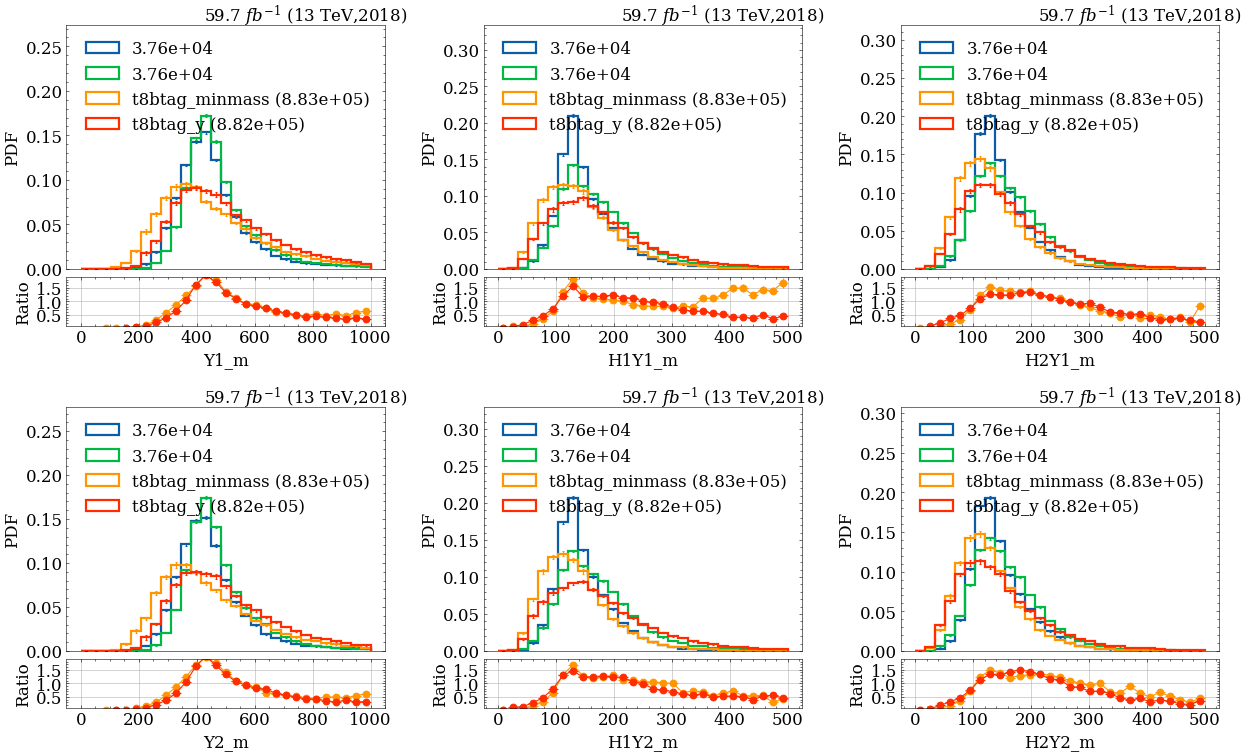

In [7]:
study.quick(
  signals+qcds,h_color=None,density=True,label=[None,None]+labels,legend=True,
  varlist=[f'{h}{obj}_m' for obj in eightb.ylist for h in ['','H1','H2']],
  dim=(-1,3), ratio=True, r_group=((0,2),(1,3))
)

In [11]:
(signals+qcds).apply(eightb.calc_m_asym)
# (signals).apply(eightb.calc_m_asym)


[None, None, None, None]

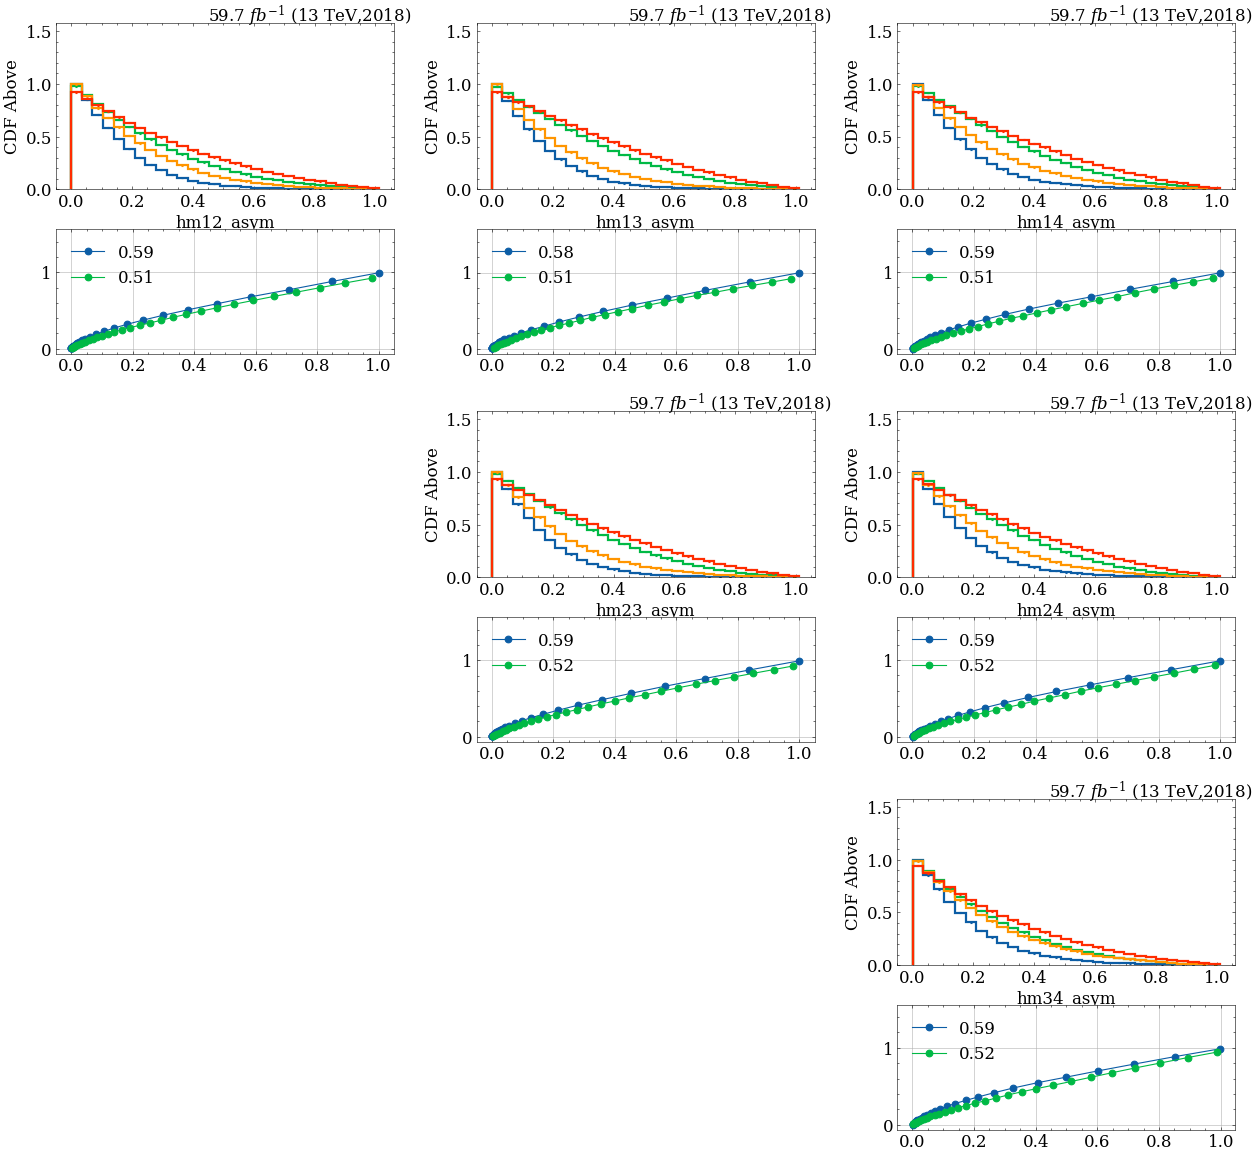

In [13]:
study.quick(
  signals+qcds,h_color=None,density=True,label=[None,None]+labels,legend=False,
  varlist=['hm12_asym','hm13_asym','hm14_asym',None,'hm23_asym','hm24_asym',None,None,'hm34_asym'],
  binlist=[(0,1.01,30)]*9,
  dim=(-1,3), 
  cumulative=-1,
  correlation=True, c_group=((0,2),(1,3)), c_label_stat='{area:0.2f}'
)

In [10]:
ak.unzip(signals[1][['H1Y1_m','H1Y2_m']])

(<Array [122, 148, 117, 233, ... 110, 196, 134] type='62904 * float32'>,
 <Array [151, 173, 84.6, 218, ... 192, 188, 201] type='62904 * float32'>)